<a href="https://colab.research.google.com/github/jeffking1998/pytorch_RS_D2L/blob/main/auto_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. TODO
train test, ratings 三个都要搞matrix 格式的，占用内存，需要解决。

## 1. Download & preprocess dataset -- MovieLens 100K


In [2]:
import pandas as pd 
import numpy as np 
import tensorflow as tf

In [15]:
# @title Load the MovieLens data (run this cell).

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# # Compute the number of movies to which a genre is assigned.
# genre_occurences = movies[genre_cols].sum().to_dict()

# # Since some movies can belong to more than one genre, we create different
# # 'genre' columns as follows:
# # - all_genres: all the active genres of the movie.
# # - genre: randomly sampled from the active genres.
# def mark_genres(movies, genres):
#   def get_random_genre(gs):
#     active = [genre for genre, g in zip(genres, gs) if g==1]
#     if len(active) == 0:
#       return 'Other'
#     return np.random.choice(active)
#   def get_all_genres(gs):
#     active = [genre for genre, g in zip(genres, gs) if g==1]
#     if len(active) == 0:
#       return 'Other'
#     return '-'.join(active)
#   movies['genre'] = [
#       get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
#   movies['all_genres'] = [
#       get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

# mark_genres(movies, genre_cols)

# # Create one merged DataFrame containing all the movielens data.
# movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [16]:
ratings.head()
rating_bkup = ratings.copy()

ratings['user_id'] = ratings['user_id'].astype(int)
ratings['movie_id'] = ratings['movie_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(int)
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [17]:
train_df, test_df = split_dataframe(ratings, 0.2)

In [18]:
print(len(ratings),
      len(train_df),
      len(test_df),
)

100000 80000 20000


In [22]:
train_np = train_df[['user_id', 'movie_id', 'rating']].to_numpy()

In [21]:
print(
    len(users),
    len(movies),
)

943 1682


In [23]:
def convert2matrix(tri_table, n_users, n_items):
    matrix = np.zeros((n_users, n_items), dtype=np.float64) 
    for t in tri_table:
        u, i, r = t 
        matrix[u,i] = r ## not 1, now has rating scores
    return matrix 

X = convert2matrix(train_np, len(users), len(movies))

In [44]:
test_np = test_df[['user_id', 'movie_id', 'rating']].to_numpy()

test_matrix = convert2matrix(test_np, len(users), len(movies))
test_mask_idx = np.sign(test_matrix)

In [70]:
ratings_np = ratings[['user_id', 'movie_id', 'rating']].to_numpy()
ratings_matrix = convert2matrix(ratings_np, len(users), len(movies))

In [24]:
X[:2, :10]

array([[5., 0., 0., 3., 0., 5., 4., 1., 0., 0.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 2.]])

In [25]:
#@title Load data from Numpy 
#reference: https://www.tensorflow.org/tutorials/load_data/numpy

train_dataset = tf.data.Dataset.from_tensor_slices((X, X))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)


In [27]:
# # idx = 0
# xxx = 0
# for train_ele in train_dataset:
#     xxx = train_ele
#     break

In [28]:
# xxx

(<tf.Tensor: shape=(64, 1682), dtype=float64, numpy=
 array([[0., 4., 0., ..., 0., 0., 0.],
        [5., 0., 0., ..., 0., 0., 0.],
        [5., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])>,
 <tf.Tensor: shape=(64, 1682), dtype=float64, numpy=
 array([[0., 4., 0., ..., 0., 0., 0.],
        [5., 0., 0., ..., 0., 0., 0.],
        [5., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])>)

In [29]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
from keras.layers import Input, Embedding, Flatten, Multiply, Dense, Concatenate
from keras import regularizers
from keras.models import Model

2.8.0


In [30]:
def get_model(data_shape, hidden_shape, regs = [0.01, 0.01]):
    model = tf.keras.Sequential(name='AutoRec')
    model.add(tf.keras.layers.InputLayer(input_shape=(data_shape,), name='input'))
    model.add(tf.keras.layers.Dense(hidden_shape, activation='sigmoid', use_bias=True, kernel_regularizer=tf.keras.regularizers.L2(regs[0]), name='encoder'))
    model.add(tf.keras.layers.Dense(units=data_shape, use_bias=True, kernel_regularizer=tf.keras.regularizers.L2(regs[1]), name='dencoder'))
    return model


data_shape = len(movies)
hidden_shape = 50
model = get_model(data_shape, hidden_shape) 

model.summary()

Model: "AutoRec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Dense)             (None, 50)                84150     
                                                                 
 dencoder (Dense)            (None, 1682)              85782     
                                                                 
Total params: 169,932
Trainable params: 169,932
Non-trainable params: 0
_________________________________________________________________


In [35]:
#@title custom loss

def my_loss(y_true, y_pred):
    mask = np.sign(y_true)
    error = tf.math.square(y_true - y_pred)
    loss = tf.reduce_sum(error * mask, axis = -1) 
    """
    因为传入的loss函数只能接收y_ture & y_pred，这样子loss要想加入对于W&V
    的l2norm就不行了。
    """
    return loss 


def my_loss_with_l2norm(model, reg_factor=0):
    def my_loss(y_true, y_pred):
        # mask = np.sign(y_true)
        mask = tf.math.sign(y_true)
        error = tf.math.square(y_true - y_pred)
        loss = tf.reduce_sum(error * mask, axis = -1)
        if reg_factor != 0:
            reg = 0
            weight = model.weights
            for w in weight:
                if 'bias' not in w.name:
                    reg += tf.reduce_sum(tf.square(w))
            loss += reg_factor * 0.5 * reg
        return loss 
    return my_loss


In [36]:
model.compile(loss=my_loss_with_l2norm(model, 0.01),optimizer=tf.keras.optimizers.Adam())

In [ ]:
# TODO
# LOSS HOW TO BUILD A LOSS 

In [63]:
#@title fit & evaluate

his = model.fit(train_dataset, epochs=100)

# model.evaluate(test_dataset)

Epoch 1/100
15/15 [==============================] - 0s 8ms/step - loss: 63.7201
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 63.6510
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 63.5250
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 63.4639
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 63.3906
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 63.3060
Epoch 7/100
15/15 [==============================] - 0s 9ms/step - loss: 63.2723
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 63.2203
Epoch 9/100
15/15 [==============================] - 0s 9ms/step - loss: 63.1466
Epoch 10/100
15/15 [==============================] - 0s 8ms/step - loss: 63.1410
Epoch 11/100
15/15 [==============================] - 0s 9ms/step - loss: 63.1206
Epoch 12/100
15/15 [==============================] - 0s 9ms/step - loss: 63.0643
Epoch 13/100
15/15 [====

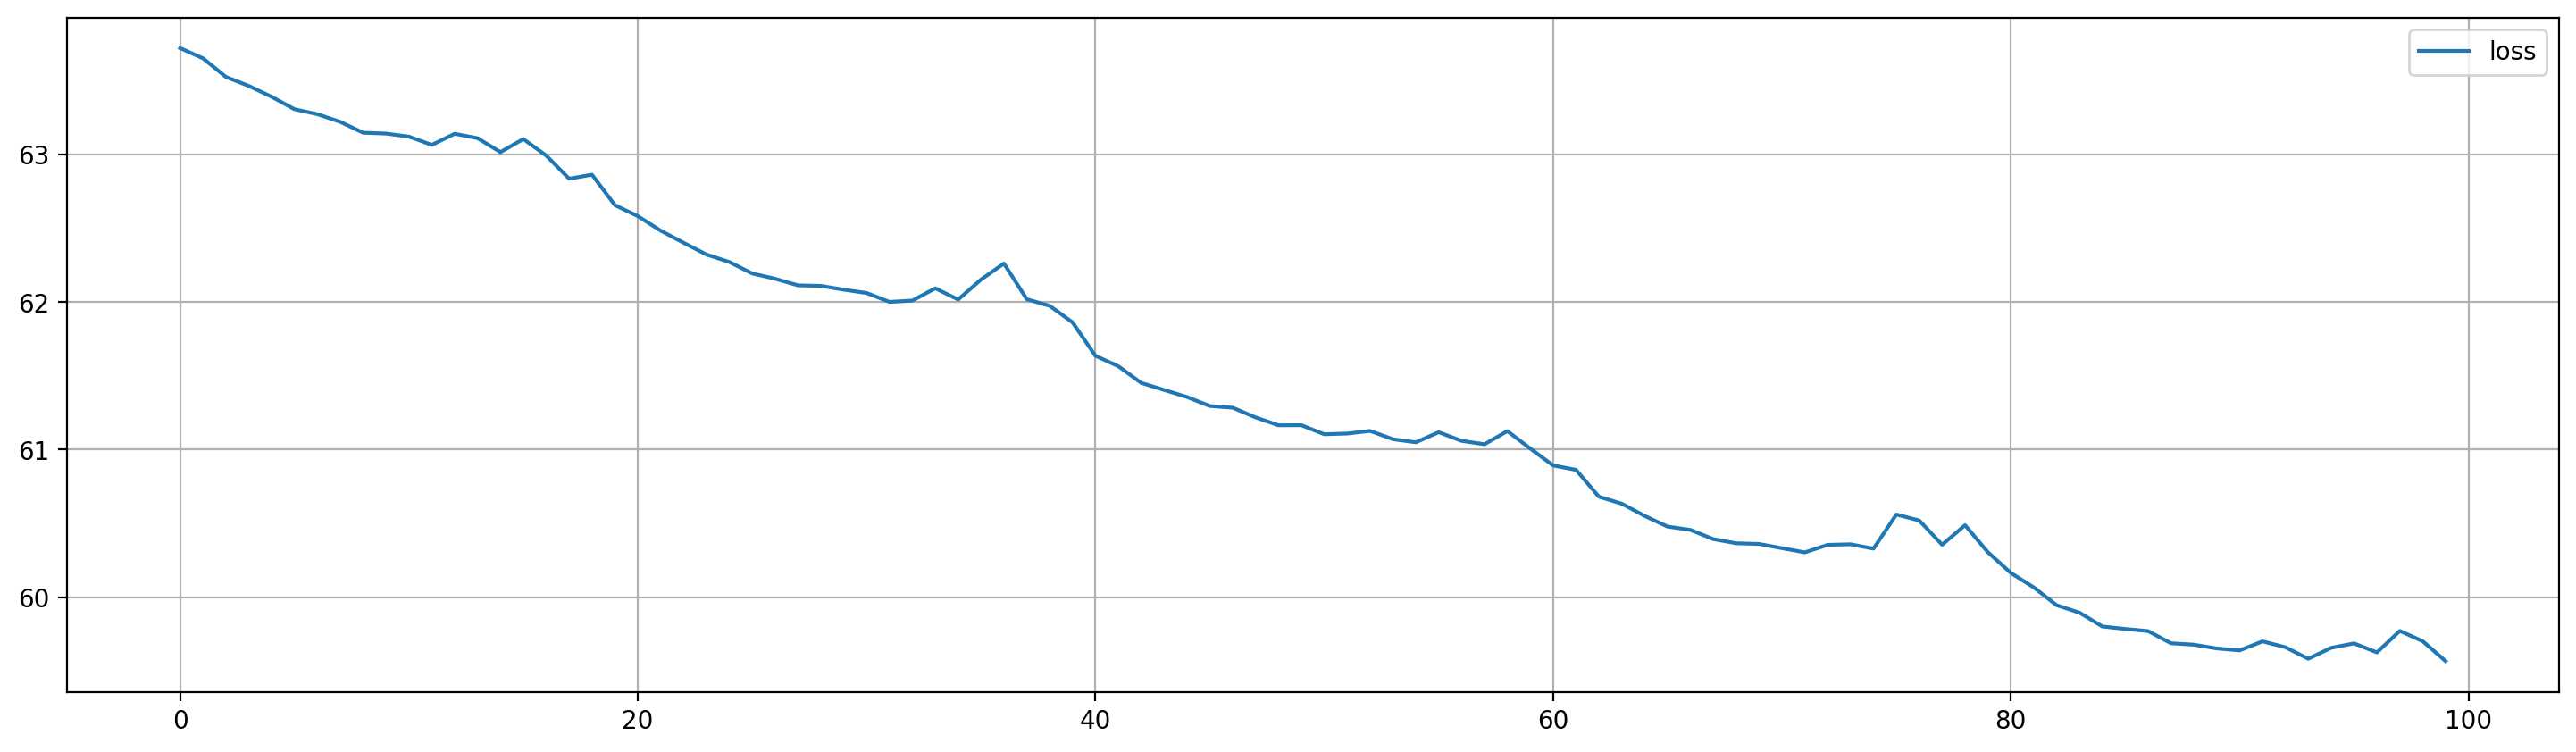

In [64]:
plt.figure(dpi=200,figsize=(18,5))
plt.plot(his.history['loss'],label='loss')
plt.legend()
plt.grid()

## evaluate 
现在的是肯定不对的

In [65]:
hat_X = model.predict(X)

In [45]:
size_test = len(test_df)

In [71]:
test_rmse = np.sqrt(np.sum(np.square((hat_X - ratings_matrix) * test_mask_idx)) / size_test)

In [72]:
test_rmse

0.9367992286925921

In [73]:
err = (hat_X - ratings_matrix) * test_mask_idx
err[:2][:10]

array([[-0.        , -0.01412344, -0.52490163, ...,  0.        ,
         0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [69]:
# X[:2][:10]

array([[5., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])